In [1]:
import os
import pandas as pd
from mlxtend.frequent_patterns import apriori, association_rules
from graphviz import Digraph
import string
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import product

/Users/anhdang/opt/anaconda3/lib/python3.8/site-packages/seaborn/rcmod.py:82: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
/Users/anhdang/opt/anaconda3/lib/python3.8/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


In [3]:
os.chdir('..')

In [4]:
!python src/pipeline.py

Traceback (most recent call last):
  File "src/pipeline.py", line 9, in <module>
    from src.ingest import process_data  # Import steps from ingest
ModuleNotFoundError: No module named 'src'


In [5]:
# Read data
df = pd.read_csv('data/01_raw/online_retail.csv')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536370,22728,ALARM CLOCK BAKELIKE PINK,24,2010-12-01 08:45:00,3.75,12583.0,France
1,536370,22727,ALARM CLOCK BAKELIKE RED,24,2010-12-01 08:45:00,3.75,12583.0,France
2,536370,22726,ALARM CLOCK BAKELIKE GREEN,12,2010-12-01 08:45:00,3.75,12583.0,France
3,536370,21724,PANDA AND BUNNIES STICKER SHEET,12,2010-12-01 08:45:00,0.85,12583.0,France
4,536370,21883,STARS GIFT TAPE,24,2010-12-01 08:45:00,0.65,12583.0,France


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44951 entries, 0 to 44950
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   InvoiceNo    44951 non-null  object 
 1   StockCode    44951 non-null  object 
 2   Description  44951 non-null  object 
 3   Quantity     44951 non-null  int64  
 4   InvoiceDate  44951 non-null  object 
 5   UnitPrice    44951 non-null  float64
 6   CustomerID   44951 non-null  float64
 7   Country      44951 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 2.7+ MB


In [7]:
# Stripping extra spaces in the description
df['Description'] = df['Description'].str.strip()


# Dropping all transactions which were done on credit
df = df[~df['InvoiceNo'].str.contains('C')]
# Dropping all UnitPrice = 0
df = df[df.UnitPrice > 0]

In [8]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,43563.000000,43563.000000,43563.000000
mean,14.449831,2.980281,13195.460597
std,13.840005,2.737978,1085.655986
min,1.000000,0.040000,12347.000000
25%,6.000000,1.250000,12484.000000
50%,12.000000,1.950000,12662.000000
75%,18.000000,3.750000,14156.000000
max,50.000000,10.000000,17844.000000


In [9]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536370,22728,ALARM CLOCK BAKELIKE PINK,24,2010-12-01 08:45:00,3.75,12583.0,France
1,536370,22727,ALARM CLOCK BAKELIKE RED,24,2010-12-01 08:45:00,3.75,12583.0,France
2,536370,22726,ALARM CLOCK BAKELIKE GREEN,12,2010-12-01 08:45:00,3.75,12583.0,France
3,536370,21724,PANDA AND BUNNIES STICKER SHEET,12,2010-12-01 08:45:00,0.85,12583.0,France
4,536370,21883,STARS GIFT TAPE,24,2010-12-01 08:45:00,0.65,12583.0,France


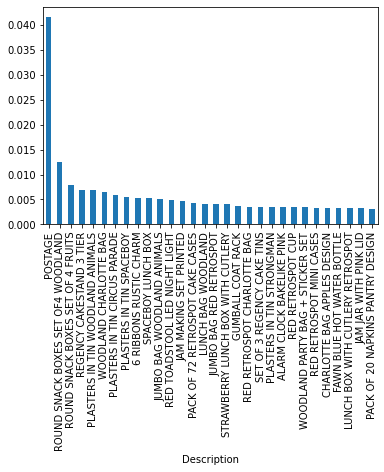

In [10]:
item_purchases_cnt = (
    df[df['Country'] =="Germany"]
    .groupby('Description').InvoiceNo.nunique()
    .sort_values(ascending=False)
)
(item_purchases_cnt / item_purchases_cnt.sum()).head(30).plot.bar();

In [11]:
top_items = (item_purchases_cnt[item_purchases_cnt.between(10, 70)]
             .reset_index()
             .rename(columns={'InvoiceNo': 'purchase_cnt'})
             .sort_values(by='purchase_cnt', ascending=False)
            )
top_items = top_items.head(50)

In [12]:
# Split transaction data by region, pivot the items within a basket
basket_GE = (df[(df['Country'] =="Germany") & df.Description.isin(top_items.Description)]
          .groupby(['InvoiceNo', 'Description'])['Quantity']
          .sum().unstack().reset_index().fillna(0)
          .set_index('InvoiceNo'))

In [13]:
basket_GE

Description,6 RIBBONS RUSTIC CHARM,ALARM CLOCK BAKELIKE PINK,BLUE POLKADOT CUP,CHARLOTTE BAG APPLES DESIGN,CHILDRENS CUTLERY DOLLY GIRL,COFFEE MUG APPLES DESIGN,FAWN BLUE HOT WATER BOTTLE,GUMBALL COAT RACK,IVORY KITCHEN SCALES,JAM JAR WITH PINK LID,...,SET/20 RED RETROSPOT PAPER NAPKINS,SET/6 RED SPOTTY PAPER CUPS,SET/6 RED SPOTTY PAPER PLATES,SKULL LUNCH BOX WITH CUTLERY,SPACEBOY LUNCH BOX,STRAWBERRY CERAMIC TRINKET BOX,STRAWBERRY LUNCH BOX WITH CUTLERY,WHITE SPOT RED CERAMIC DRAWER KNOB,WOODLAND CHARLOTTE BAG,WOODLAND PARTY BAG + STICKER SET
InvoiceNo,,,,,,,,,,,,,,,,,,,,,
536527,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536840,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536861,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536967,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536983,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581266,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,50.0,0.0,0.0,0.0,10.0,0.0
581494,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0
581570,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0


In [14]:
# Defining the hot encoding function to make the data suitable 
# for the concerned libraries
def hot_encode(x):
    if(x<= 0):
        return 0
    if(x>= 1):
        return 1

In [15]:
basket_encoded = basket_GE.applymap(hot_encode)
basket_GE = basket_encoded
basket_GE

Description,6 RIBBONS RUSTIC CHARM,ALARM CLOCK BAKELIKE PINK,BLUE POLKADOT CUP,CHARLOTTE BAG APPLES DESIGN,CHILDRENS CUTLERY DOLLY GIRL,COFFEE MUG APPLES DESIGN,FAWN BLUE HOT WATER BOTTLE,GUMBALL COAT RACK,IVORY KITCHEN SCALES,JAM JAR WITH PINK LID,...,SET/20 RED RETROSPOT PAPER NAPKINS,SET/6 RED SPOTTY PAPER CUPS,SET/6 RED SPOTTY PAPER PLATES,SKULL LUNCH BOX WITH CUTLERY,SPACEBOY LUNCH BOX,STRAWBERRY CERAMIC TRINKET BOX,STRAWBERRY LUNCH BOX WITH CUTLERY,WHITE SPOT RED CERAMIC DRAWER KNOB,WOODLAND CHARLOTTE BAG,WOODLAND PARTY BAG + STICKER SET
InvoiceNo,,,,,,,,,,,,,,,,,,,,,
536527,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536840,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
536861,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536967,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536983,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581266,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
581494,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
581570,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [16]:
frq_items = apriori(basket_GE, min_support = 0.03, use_colnames = True)
rules = association_rules(frq_items, metric ="lift", min_threshold = 1)
rules = rules.sort_values(['confidence', 'lift'], ascending =[False, False])

/Users/anhdang/opt/anaconda3/lib/python3.8/site-packages/mlxtend/frequent_patterns/fpcommon.py:111: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


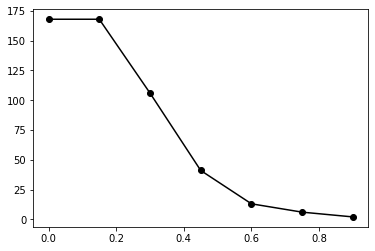

In [17]:
# Choise of support/confidence
# Source: https://www.kaggle.com/code/xvivancos/market-basket-analysis/report
# Lower the support: Having more rules, with high confidence level
confidence_levels = np.arange(0, 1, 0.15)
num_rules = []
for thres_lvl in confidence_levels:
    rule_cnt = rules[rules.confidence > thres_lvl].shape[0]
    num_rules.append(rule_cnt)
    
df_confidence_rule_cnt = pd.DataFrame({
    'confidence_level': confidence_levels,
    'num_rules': num_rules
}).set_index('confidence_level')

plt.plot(confidence_levels, num_rules, 'o-', color='black');

In [18]:
rules[rules.confidence > 0.6]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
140,"(WOODLAND CHARLOTTE BAG, JUMBO BAG RED RETROSPOT)",(JUMBO BAG WOODLAND ANIMALS),0.030812,0.128852,0.030812,1.000000,7.760870,0.026842,inf
162,"(RED RETROSPOT CHARLOTTE BAG, RED TOADSTOOL LE...",(WOODLAND CHARLOTTE BAG),0.030812,0.162465,0.030812,1.000000,6.155172,0.025806,inf
133,(SET/6 RED SPOTTY PAPER CUPS),(SET/6 RED SPOTTY PAPER PLATES),0.067227,0.072829,0.058824,0.875000,12.014423,0.053927,7.417367
106,(RED RETROSPOT CHARLOTTE BAG),(WOODLAND CHARLOTTE BAG),0.089636,0.162465,0.075630,0.843750,5.193427,0.061068,5.360224
132,(SET/6 RED SPOTTY PAPER PLATES),(SET/6 RED SPOTTY PAPER CUPS),0.072829,0.067227,0.058824,0.807692,12.014423,0.053927,4.850420
157,"(PLASTERS IN TIN STRONGMAN, PLASTERS IN TIN SP...",(PLASTERS IN TIN WOODLAND ANIMALS),0.039216,0.176471,0.030812,0.785714,4.452381,0.023892,3.843137
11,(BLUE POLKADOT CUP),(RED RETROSPOT CUP),0.061625,0.089636,0.044818,0.727273,8.113636,0.039294,3.338002
146,"(PLASTERS IN TIN CIRCUS PARADE, PLASTERS IN TI...",(PLASTERS IN TIN WOODLAND ANIMALS),0.061625,0.176471,0.044818,0.727273,4.121212,0.033943,3.019608
156,"(PLASTERS IN TIN STRONGMAN, PLASTERS IN TIN WO...",(PLASTERS IN TIN SPACEBOY),0.044818,0.137255,0.030812,0.687500,5.008929,0.024661,2.760784
74,(PLASTERS IN TIN STRONGMAN),(PLASTERS IN TIN CIRCUS PARADE),0.089636,0.148459,0.061625,0.687500,4.630896,0.048317,2.724930


In [19]:
df_viz = rules#.head(30)
df_viz = df_viz.explode('antecedents')
df_viz.explode('consequents')
df_viz['consequents'] = df_viz.consequents.apply(lambda x: list(x)[0])

In [20]:
df_viz

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
140,WOODLAND CHARLOTTE BAG,JUMBO BAG WOODLAND ANIMALS,0.030812,0.128852,0.030812,1.000000,7.760870,0.026842,inf
140,JUMBO BAG RED RETROSPOT,JUMBO BAG WOODLAND ANIMALS,0.030812,0.128852,0.030812,1.000000,7.760870,0.026842,inf
162,RED RETROSPOT CHARLOTTE BAG,WOODLAND CHARLOTTE BAG,0.030812,0.162465,0.030812,1.000000,6.155172,0.025806,inf
162,RED TOADSTOOL LED NIGHT LIGHT,WOODLAND CHARLOTTE BAG,0.030812,0.162465,0.030812,1.000000,6.155172,0.025806,inf
133,SET/6 RED SPOTTY PAPER CUPS,SET/6 RED SPOTTY PAPER PLATES,0.067227,0.072829,0.058824,0.875000,12.014423,0.053927,7.417367
...,...,...,...,...,...,...,...,...,...
6,PLASTERS IN TIN WOODLAND ANIMALS,ALARM CLOCK BAKELIKE PINK,0.176471,0.089636,0.030812,0.174603,1.947917,0.014994,1.102941
93,REGENCY CAKESTAND 3 TIER,PLASTERS IN TIN STRONGMAN,0.176471,0.089636,0.030812,0.174603,1.947917,0.014994,1.102941
100,PLASTERS IN TIN WOODLAND ANIMALS,STRAWBERRY LUNCH BOX WITH CUTLERY,0.176471,0.100840,0.030812,0.174603,1.731481,0.013017,1.089367
98,PLASTERS IN TIN WOODLAND ANIMALS,SPACEBOY LUNCH BOX,0.176471,0.131653,0.030812,0.174603,1.326241,0.007580,1.052036


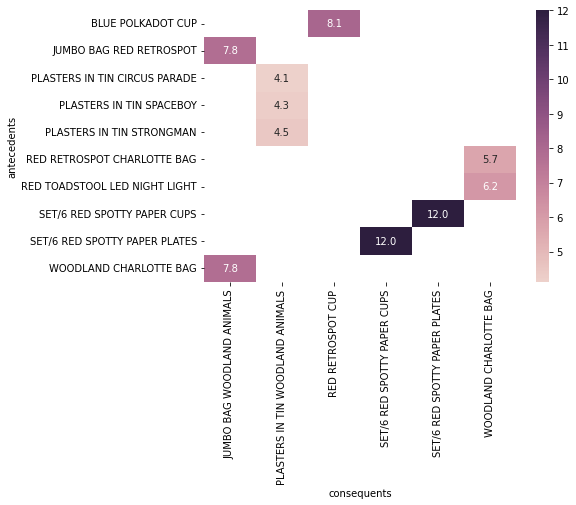

In [21]:
df_heatmap = (df_viz[df_viz.confidence >= 0.7]
              .groupby(['antecedents', 'consequents']).lift.mean()
              .reset_index()
              .pivot(index='antecedents', columns='consequents', values='lift')
             )
plt.figure(figsize=(7, 5))
sns.heatmap(df_heatmap, annot=True, fmt='.1f', cmap=sns.cubehelix_palette(as_cmap=True));

In [22]:
df_viz = df_viz[df_viz.confidence >= 0.7]
associated_items_ls = pd.concat([df_viz.antecedents, df_viz.consequents]).unique()
nodes_df = top_items[top_items.Description.isin(associated_items_ls)]

In [23]:
alphabet_nodeid = list(string.ascii_lowercase) 
alphanum_nodeid = alphabet_nodeid + [str(i) for i in range(9)]
nodes_df['node_id'] = [alphanum_nodeid[i] for i in range(len(nodes_df))]
nodes_df

/var/folders/tn/xpr0bd8x39d87tc_djfk2p2w0000gn/T/ipykernel_8352/166266147.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nodes_df['node_id'] = [alphanum_nodeid[i] for i in range(len(nodes_df))]


,Description,purchase_cnt,node_id
1,PLASTERS IN TIN WOODLAND ANIMALS,63,a
2,WOODLAND CHARLOTTE BAG,58,b
3,PLASTERS IN TIN CIRCUS PARADE,53,c
4,PLASTERS IN TIN SPACEBOY,49,d
7,JUMBO BAG WOODLAND ANIMALS,46,e
8,RED TOADSTOOL LED NIGHT LIGHT,44,f
12,JUMBO BAG RED RETROSPOT,36,g
17,PLASTERS IN TIN STRONGMAN,32,h
19,RED RETROSPOT CUP,32,i
15,RED RETROSPOT CHARLOTTE BAG,32,j


In [24]:
nodes_id_dict = {r.Description: r.node_id for _, r in nodes_df.iterrows()}

In [25]:
df_viz = df_viz[df_viz.confidence >= 0.7]
df_viz['from_node_id'] = df_viz.antecedents.apply(lambda x: nodes_id_dict[x])
df_viz['to_node_id'] = df_viz.consequents.apply(lambda x: nodes_id_dict[x])
df_viz['edge'] = df_viz.from_node_id + df_viz.to_node_id

In [26]:
df_viz['edge_dedup'] = df_viz.edge.apply(lambda x: ''.join(sorted(x)))
df_viz['higher_confidence_dir'] = df_viz.groupby('edge_dedup').confidence.transform('max')
df_viz[df_viz.confidence == df_viz.higher_confidence_dir].edge

140    be
140    ge
162    jb
162    fb
133    lk
157    ha
157    da
11     mi
146    ca
Name: edge, dtype: object

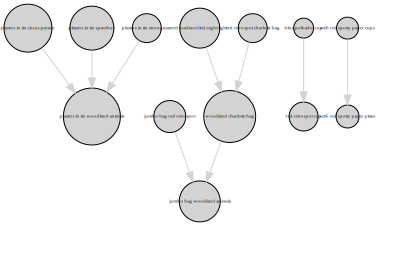

In [27]:
scaled_size = 80
gra = Digraph(edge_attr={'color':'lightgray'},
              node_attr={'shape': 'circle', 'fixedsize':'true', 'style': 'filled', 'fontsize': '5'},
              graph_attr={'beautify':'true', 'margin': '0.5'},
              format='pdf'
             )

for _, r in nodes_df.iterrows():
    gra.node(r.node_id, r.Description.lower(), **{'width':str(r.purchase_cnt/scaled_size)})

gra.edges(df_viz[df_viz.confidence == df_viz.higher_confidence_dir].edge.tolist())
gra

In [29]:
gra.render('data/04_model_output/GE-top-items-associations', view=True)  

'data/04_model_output/GE-top-items-associations.pdf'

Makefile         data             pyproject.toml   tests
README.md        notebooks        requirements.txt
config           poetry.lock      src
